# The functionality for composing linear model features

`feature-encoders` includes a `ModelStructure` class for aggregating feature generators and encoders into main effect and pairwise interaction terms for linear regression models. 

A `ModelStructure` instance can get information about features and encoders either from YAML files or through its API.

In [1]:
import calendar
import json
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from feature_encoders.utils import load_config
from feature_encoders.compose import ModelStructure, FeatureComposer
from feature_encoders.generate import DatetimeFeatures
from feature_encoders.models import SeasonalPredictor

## Reading information from YAML files

`feature-encoders` expects two YAML files:

### Feature generator file

A file that provides a mapping between the name of a feature generator and the classes that should be used for the validation of its inputs and for its creation:

```yaml
trend:
  validate: validate.TrendSchema
  generate: generate.TrendFeatures

datetime:
  validate: validate.DatetimeSchema
  generate: generate.DatetimeFeatures

cyclical:
  validate: validate.CyclicalSchema
  generate: generate.CyclicalFeatures
```

By default, `ModelStructure` searches in `feature_encoders.config` to find the validation and generation classes, but one can add packages by adding the fully qualified names of the corresponding classes.

### Model configuration file

These files have three sections: (a) added features, (b) regressors and (c) interactions.

#### Added features

The information in this section is passed to one of the feature generators in `feature_encoder.generate`:


```yaml
add_features:
  time: # the name of the generator
  ds: null 
  type: datetime
  remainder: passthrough
  subset: month, hourofweek
```

#### Regressors

The information for each regressor includes its name, the name of the feature to use and encode so that to create this regressor, the type of the encoder (linear, spline or categorical), and the parameters to pass to the corresponding encoder class from `feature_encoders.encode`:

```yaml
regressors:
  month:                 # the name of the regressor
    feature: month       # the name of the feature 
    type: categorical
    max_n_categories: null
    encode_as: onehot 

  tow:                   # the name of the regressor
    feature: hourofweek  # the name of the feature 
    type: categorical
    max_n_categories: 60 
    encode_as: onehot 

  flex_temperature:
    feature: temperature
    type: spline
    n_knots: 5
    degree: 1
    strategy: uniform 
    extrapolation: constant
    interaction_only: true  # if True, it will not be included in the main features

```


#### Interactions

Interactions can introduce new regressors, reuse regressors already defined in the regressors section, as well as alter the parameters of regressors that are already defined in the regressors section:

```yaml
interactions:
  tow, flex_temperature:
    tow:
      max_n_categories: 2 
      stratify_by: temperature 
      min_samples_leaf: 15 
```

### Load configuration files

In [3]:
model_conf, feature_conf = load_config(model='towt', features='default')

In [4]:
print(json.dumps(model_conf, indent=4))

{
    "add_features": {
        "time": {
            "type": "datetime",
            "subset": "month, hourofweek"
        }
    },
    "regressors": {
        "month": {
            "feature": "month",
            "type": "categorical",
            "encode_as": "onehot"
        },
        "tow": {
            "feature": "hourofweek",
            "type": "categorical",
            "max_n_categories": 60,
            "encode_as": "onehot"
        },
        "lin_temperature": {
            "feature": "temperature",
            "type": "linear"
        },
        "flex_temperature": {
            "feature": "temperature",
            "type": "spline",
            "n_knots": 5,
            "degree": 1,
            "strategy": "uniform",
            "extrapolation": "constant",
            "include_bias": true,
            "interaction_only": true
        }
    },
    "interactions": {
        "tow, flex_temperature": {
            "tow": {
                "max_n_categories": 2,
         

In [5]:
print(json.dumps(feature_conf, indent=4))

{
    "trend": {
        "validate": "validate.TrendSchema",
        "generate": "generate.TrendFeatures"
    },
    "datetime": {
        "validate": "validate.DatetimeSchema",
        "generate": "generate.DatetimeFeatures"
    },
    "cyclical": {
        "validate": "validate.CyclicalSchema",
        "generate": "generate.CyclicalFeatures"
    }
}


### Create `ModelStructure`

In [6]:
model_structure = ModelStructure.from_config(model_conf, feature_conf)

In [7]:
for key, val in model_structure.components.items():
    print(key, '-->', val.keys())

add_features --> dict_keys(['time'])
main_effects --> dict_keys(['month', 'tow', 'lin_temperature'])
interactions --> dict_keys([('tow', 'flex_temperature')])


### Create `FeatureComposer`

Given the model structure, we can create and apply a `FeatureComposer`:

In [8]:
composer = FeatureComposer(model_structure)

### Load demo data

In [9]:
data = pd.read_csv('data/data.csv', parse_dates=[0], index_col=0)
data = data[~data['consumption_outlier']]

### Use the `FeatureComposer`

In [10]:
X = data[['temperature']]
y = data['consumption']

composer = composer.fit(X, y)

The `fit` method of the composer calls two methods: `_create_new_features` and `_create_encoders`. The feature generators are applied in the same order that they were declared in the YAML configuration file.

In [11]:
for item in composer.added_features_:
    print(item)

DatetimeFeatures(subset=['month', 'hourofweek'])


In [12]:
for name, encoder in composer.encoders_['main_effects'].items():
    print('-->', name)
    print(encoder)

--> month
CategoricalEncoder(feature='month')
--> tow
CategoricalEncoder(feature='hourofweek', max_n_categories=60)
--> lin_temperature
IdentityEncoder(feature='temperature')


In [13]:
for pair_name, encoder in composer.encoders_['interactions'].items():
    print('-->', pair_name)
    print(encoder)

--> ('tow', 'flex_temperature')
ICatSplineEncoder(encoder_cat=CategoricalEncoder(feature='hourofweek',
                                                 max_n_categories=2,
                                                 min_samples_leaf=15,
                                                 stratify_by=['temperature']),
                  encoder_num=SplineEncoder(degree=1, feature='temperature'))


After fitting, a composer has a `component_names_` attribute:

In [14]:
composer.component_names_

['lin_temperature', 'month', 'tow', 'tow:flex_temperature']

It also has a `component_matrix` attribute that shows how the different columns of the [design matrix](https://en.wikipedia.org/wiki/Design_matrix) correspond to the different components. This allows us to break down a model's prediction into the additive contribution of each component.

In [15]:
composer.component_matrix

component,lin_temperature,month,tow,tow:flex_temperature
col,,,,
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
78,0,0,0,1
79,0,0,0,1
80,0,0,0,1


The design matrix is constructed by transforming the data:   

In [16]:
design_matrix = composer.transform(X)

In [17]:
assert design_matrix.shape[0] == X.shape[0]
assert design_matrix.shape[1] == composer.component_matrix.shape[0]

In [18]:
n_features = 0

for encoder in composer.encoders_['main_effects'].values():
    n_features += encoder.n_features_out_
    
for encoder in composer.encoders_['interactions'].values():
    n_features += encoder.n_features_out_
    
assert design_matrix.shape[1] == n_features

## Using the API

An example of using the `ModelStructure` API can be found in `feature_encoders.models.SeasonalPredictor`:

```python
def _create_composer(self):
    model_structure = ModelStructure()

    if self.add_trend:
        model_structure = model_structure.add_new_feature(
            name="added_trend",
            fgen_type=TrendFeatures(
                ds=self.ds,
                name="growth",
                remainder="passthrough",
                replace=False,
            ),
        )
        model_structure = model_structure.add_main_effect(
            name="trend",
            enc_type=IdentityEncoder(
                feature="growth",
                as_filter=False,
                include_bias=False,
            ),
        )

    for seasonality, props in self.seasonalities_.items():
        condition_name = props["condition_name"]

        model_structure = model_structure.add_new_feature(
            name=seasonality,
            fgen_type=CyclicalFeatures(
                seasonality=seasonality,
                ds=self.ds,
                period=props.get("period"),
                fourier_order=props.get("fourier_order"),
                remainder="passthrough",
                replace=False,
            ),
        )

        if condition_name is None:
            model_structure = model_structure.add_main_effect(
                name=seasonality,
                enc_type=IdentityEncoder(
                    feature=seasonality,
                    as_filter=True,
                    include_bias=False,
                ),
            )
        else:
            model_structure = model_structure.add_interaction(
                lenc_name=condition_name,
                renc_name=seasonality,
                lenc_type=CategoricalEncoder(
                    feature=condition_name, encode_as="onehot"
                ),
                renc_type=IdentityEncoder(
                    feature=seasonality, as_filter=True, include_bias=False
                ),
            )
    return FeatureComposer(model_structure)
```

In [19]:
model = SeasonalPredictor(
        ds=None,
        add_trend=True,
        yearly_seasonality="auto",
        weekly_seasonality=False,
        daily_seasonality=False,
)

We can add a different daily seasonality per day of week:

In [20]:
X = DatetimeFeatures(subset='dayofweek').fit_transform(X)
X['dayofweek'] = X['dayofweek'].map(lambda x: calendar.day_abbr[x])
X = X.merge(pd.get_dummies(X['dayofweek']), 
            left_index=True, 
            right_index=True).drop('dayofweek', axis=1
)

In [21]:
for i in range(7):
    day = calendar.day_abbr[i]
    model.add_seasonality(
        f"daily_on_{day}", period=1, fourier_order=4, condition_name=day
    )

In [22]:
model = model.fit(X, y)

In [23]:
for item in model.composer_.added_features_:
    print(item)

TrendFeatures()
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Mon')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Tue')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Wed')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Thu')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Fri')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Sat')
CyclicalFeatures(fourier_order=4, period=1.0, seasonality='daily_on_Sun')
CyclicalFeatures(fourier_order=6, period=365.25, seasonality='yearly')


In [24]:
for name, encoder in model.composer_.encoders_['main_effects'].items():
    print('-->', name)
    print(encoder)

--> trend
IdentityEncoder(feature='growth')
--> yearly
IdentityEncoder(as_filter=True, feature='yearly')


In [25]:
for pair_name, encoder in model.composer_.encoders_['interactions'].items():
    print('-->', pair_name)
    print(encoder)

--> ('Mon', 'daily_on_Mon')
ICatLinearEncoder(encoder_cat=CategoricalEncoder(feature='Mon'),
                  encoder_num=IdentityEncoder(as_filter=True,
                                              feature='daily_on_Mon'))
--> ('Tue', 'daily_on_Tue')
ICatLinearEncoder(encoder_cat=CategoricalEncoder(feature='Tue'),
                  encoder_num=IdentityEncoder(as_filter=True,
                                              feature='daily_on_Tue'))
--> ('Wed', 'daily_on_Wed')
ICatLinearEncoder(encoder_cat=CategoricalEncoder(feature='Wed'),
                  encoder_num=IdentityEncoder(as_filter=True,
                                              feature='daily_on_Wed'))
--> ('Thu', 'daily_on_Thu')
ICatLinearEncoder(encoder_cat=CategoricalEncoder(feature='Thu'),
                  encoder_num=IdentityEncoder(as_filter=True,
                                              feature='daily_on_Thu'))
--> ('Fri', 'daily_on_Fri')
ICatLinearEncoder(encoder_cat=CategoricalEncoder(feature='Fri'),
   

In [26]:
prediction = model.predict(X)

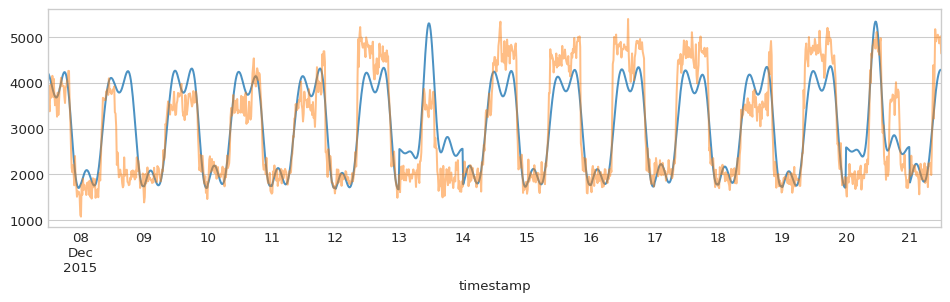

In [27]:
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))
    
    prediction['consumption'][:1344].plot(ax=ax, alpha=0.8) #2 weeks data
    y[:1344].plot(ax=ax, alpha=0.5)

### Consistency checks 

In [28]:
design_matrix = model.composer_.transform(X)

In [29]:
for i in range(7):
    day = calendar.day_abbr[i]

    subset_index = model.composer_.component_matrix[
                    model.composer_.component_matrix[f'{day}:daily_on_{day}'] == 1
                   ].index
    subset = pd.DataFrame(design_matrix[:, subset_index], index=X.index)
    
    features_on = subset.columns[(subset.loc[X[X[day]==1].index] == 0).all()]
    features_off = subset.columns[(subset.loc[X[X[day]==0].index] == 0).all()]

    assert features_on.intersection(features_off).empty

The model works even if we replace:

```python
model_structure = model_structure.add_interaction(
    lenc_name=condition_name,
    renc_name=seasonality,
    lenc_type=CategoricalEncoder(
        feature=condition_name, encode_as="onehot"
    ),
    renc_type=IdentityEncoder(
        feature=seasonality, as_filter=True, include_bias=False
    ),
)
```

with

```python
model_structure = model_structure.add_interaction(
    lenc_name=condition_name,
    renc_name=seasonality,
    lenc_type="categorical",
    right_enc_type="linear",
    left_feature=condition_name,
    renc_type=seasonality,
    **{
        condition_name: {"encode_as": "onehot"},
        seasonality: {"as_filter": True, "include_bias": False},
    },
)
```

because the `FeatureComposer` maps "categorical" to `CategoricalEncoder`, "linear" to `IdentityEncoder` and "spline" to `SplineEncoder`, and passes all additional keyword arguments to the corresponding initializers.

------------